# 최종수정일: 2022-05-27

- ucsv_dp.m (Stock and Watson 2016) converted to python
- ind_eps, g_eps, sigma_eps are sampled by SVRW function (from Chan 2018)
    - SVRW function is modified to use the mixture of 10 normal distributions instead of 7.
- tau and dtau are sampled by a cython version of sample_tau function, which is 3X faster.

In [1]:
%run sw2016_function   # magic command: as cmd window
%load_ext Cython

In [2]:
def sample_tau_cython(y, sigma_dtau, sigma_eps_scl):
    small = 1e-6; big = 1e6
    # P matrices
    nobs = len(y)
    # Kalman Filter using special structure of problem
    x0 = y[0]
    P0 = big
    rand1 = nsample(nobs)   # sw2016_function
    rand2 = nsample(nobs + 1)  # sw2016_function
    Q = np.array(sigma_dtau**2, float, order="F")  # 'F'ortran order (column major)
    R = np.array(sigma_eps_scl**2, float, order="F")
    tau_a, tau_f = sample_dtau_by_kalman(Q, R, x0, P0, y, rand1, rand2)
    dtau = tau_a[1:] - tau_a[:-1]
    tau = tau_a[1:]
    return tau, dtau, tau_f

In [3]:
%%cython

cimport numpy as cnp
import numpy as np
cimport scipy.linalg.cython_lapack as cython_lapack
cimport scipy.linalg.cython_blas as cython_blas
from libc.stdlib cimport malloc, free

# cython: boundscheck=False, wraparound=False, nonecheck=False, initializedcheck=False
cimport cython
cimport scipy.linalg.cython_blas as blas
from scipy.linalg.cython_lapack cimport dpotrf, dpotrs, dlacpy

ctypedef cnp.float64_t REAL_t   # double

cdef extern from "math.h":
    REAL_t log(REAL_t x)
    

def sample_dtau_by_kalman(REAL_t[::1] Q, REAL_t[::1] R, REAL_t x_init, REAL_t P_init, 
              REAL_t[::1] y, REAL_t[::1] rand1, REAL_t[::1] rand2):
    
    cdef REAL_t x, x0, x1, xT, P0, P1, PT, K, AS, x_
    cdef REAL_t[::1] x_p, x_u, P_p, P_u
    cdef int t, T

    T = y.shape[0]  # number of observations
    
    x_ = x_init
    x0 = x_init
    P0 = P_init
    
    P_u = np.zeros(T + 1, float, order="F")
    P_p = np.zeros(T + 1, float, order="F")
    x_u = np.zeros(T + 1, float, order="F")
    x_p = np.zeros(T + 1, float, order="F")
    x_u[0] = x0
    P_u[0] = P0
    
    tau_a = np.zeros(T + 1, float, order="F")
    tau_f = np.zeros(T, float, order="F")
    
    for t in range(T):
        x1 = x0 + (x0 - x_)    # τ_t|t-1 = τ_t-1|t-1 + Δτ_t-1|t-1 + ϵ_t
        x_ = x0                # set x_1 
        P1 = P0 + Q[t]
        Ht = P1 + R[t]
        K = P1/Ht
        x0 = x1 + K*(y[t] - x1)
        P0 = P1 - K*P1
        x_u[t+1] = x0
        P_u[t+1] = P0
        x_p[t+1] = x1
        P_p[t+1] = P1
        # Generate random draw from filtered mean and variance 
        tau_f[t] = x0 + np.sqrt(P0)*rand1[t]

    # Generate Random Draws from Smoothed Distribution 
    xT = x0
    PT = P0
    x = xT + np.sqrt(PT)*rand2[T]
    tau_a[T] = x

    for t in range(1, T)[::-1]:
        x1 = x_p[t+1]
        P1 = P_p[t+1]
        x0 = x_u[t]
        P0 = P_u[t]
        AS = P0/P1
        xT = x0 + AS*(x - x1)
        PT = P0 - AS*P0
        x = xT + np.sqrt(PT)*rand2[t]
        tau_a[t] = x
        
    return np.array(tau_a), np.array(tau_f)

In [4]:
%%cython

cimport numpy as cnp
import numpy as np
cimport scipy.linalg.cython_lapack as cython_lapack
cimport scipy.linalg.cython_blas as cython_blas
from libc.stdlib cimport malloc, free

# cython: boundscheck=False, wraparound=False, nonecheck=False, initializedcheck=False
cimport cython
cimport scipy.linalg.cython_blas as blas
from scipy.linalg.cython_lapack cimport dpotrf, dpotrs, dlacpy

ctypedef cnp.float64_t REAL_t   # double

cdef extern from "math.h":
    REAL_t log(REAL_t x)
    

def sample_tau_by_kalman(REAL_t[::1] Q, REAL_t[::1] R, REAL_t x_init, REAL_t P_init, 
              REAL_t[::1] y, REAL_t[::1] rand1, REAL_t[::1] rand2):
    
    cdef REAL_t x, x0, x1, xT, P0, P1, PT, K, AS
    cdef REAL_t[::1] x_p, x_u, P_p, P_u, 
    cdef int t, T

    T = y.shape[0]  # number of observations
    
    x0 = x_init
    P0 = P_init
    
    P_u = np.zeros(T + 1, float, order="F")
    P_p = np.zeros(T + 1, float, order="F")
    x_u = np.zeros(T + 1, float, order="F")
    x_p = np.zeros(T + 1, float, order="F")
    x_u[0] = x0
    P_u[0] = P0
    
    tau_a = np.zeros(T + 1, float, order="F")
    tau_f = np.zeros(T, float, order="F")
    
    for t in range(T):
        x1 = x0
        P1 = P0 + Q[t]
        Ht = P1 + R[t]
        K = P1/Ht
        x0 = x1 + K*(y[t] - x1)
        P0 = P1 - K*P1
        x_u[t+1] = x0
        P_u[t+1] = P0
        x_p[t+1] = x1
        P_p[t+1] = P1
        # Generate random draw from filtered mean and variance 
        tau_f[t] = x0 + np.sqrt(P0)*rand1[t]

    # Generate Random Draws from Smoothed Distribution 
    xT = x0
    PT = P0
    x = xT + np.sqrt(PT)*rand2[T]
    tau_a[T] = x

    for t in range(1, T)[::-1]:
        x1 = x_p[t+1]
        P1 = P_p[t+1]
        x0 = x_u[t]
        P0 = P_u[t]
        AS = P0/P1
        xT = x0 + AS*(x - x1)
        PT = P0 - AS*P0
        x = xT + np.sqrt(PT)*rand2[t]
        tau_a[t] = x
        
    return np.array(tau_a), np.array(tau_f)

# Data and Parameters

# daily 2018 이후

In [115]:
#################################################
# 2017-9-29 와 2017-10-10 사이에 값이 비어 있음
#################################################
# weekly data => data.loc['2017-10-08', 'er'] = (1137.88 + 1138.20)/2
# data.loc[data.isnull()]
df = pd.read_csv('원화대미달러.csv', header=None, index_col=0).dropna()
df.index = pd.to_datetime(df.index)
df.index.names = [None]
df.columns = ['er']

data = df.resample('W').last().loc['2005':]
data.loc['2017-10-08'] = (data.shift().loc['2017-10-08'] + data.shift(-1).loc['2017-10-08'])/2
y = data['er'].to_numpy().T
len(y)

909

In [ ]:
df_tau_mean = pd.DataFrame()
df_dtau_mean = pd.DataFrame()
df_sigma_dtau_mean = pd.DataFrame()
df_sigma_eps_mean = pd.DataFrame()
df_scl_eps_mean = pd.DataFrame()
df_sigma_total_eps_mean = pd.DataFrame()
df_g_eps_draws = pd.DataFrame()
df_g_dtau_draws = pd.DataFrame()
df_ps_draws = pd.DataFrame()

for last_date in data.loc['2018'].index:
    print(last_date)
    
    y = data.loc[:last_date, 'er'].to_numpy().T

    # Prior Procedure part 1

    T = len(y)                  # number of observations (CPI inflation)
    nper = 52                   # number of observations per year (weekly 52, daily 252, monthly 12)

    # number of draws
    n_draws = 15000                     # total number of draws  

    ### scale data
    scale_y = np.std(y[1:] - y[:-1])/5  # scaler
    yn = y/scale_y                      # standardized (scaled) CPI inflation

    # prior: h, h_tilde, g, g_tilde...
    a0 = 0; b0 = 10; Vomega = .2
    n_grid = 500; # number of grid points
    omh_grid = np.linspace(-1, 1, n_grid)
    omg_grid = np.linspace(-1, 1, n_grid)
    priden_omh = stats.norm.pdf(omh_grid, 0, np.sqrt(Vomega))  # prior dist of omegah
    priden_omg = stats.norm.pdf(omg_grid, 0, np.sqrt(Vomega))  # prior dist of omegag

    # initialize the Markov chain
    h0 = log(stat.variance(y))/1
    g0 = log(stat.variance(y[1:] - y[:-1]))/1
    tau0 = mean(y)
    dtau0 = mean(y[1:] - y[:-1])
    omegah = sqrt(.2)/1
    omegag = sqrt(.2)/1
    h_tilde = zeros(T)
    g_tilde = zeros(T)
    h = h0 + omegah*h_tilde
    g = g0 + omegah*g_tilde 

    ### scale mixture of epsilon component
    scl_eps_vec = np.arange(1, 11) # [1, 2, ... , 10]
    ps_prior = np.array([1-1/(4*nper), 1/(4*nper)]) * nper * 10

    # Initial value of ps
    n_scl_eps = len(scl_eps_vec)
    ps = ps_prior[0]/ps_prior.sum()
    prob_scl_eps_vec = ps*np.ones(n_scl_eps); prob_scl_eps_vec[1:] = (1-ps)/(n_scl_eps-1);

    # SET initial values for σ_et σ_τt, s_t: sigma = 1, scale_eps is unity
    sigma_eps = np.ones(T)
    sigma_dtau = np.ones(T)
    scale_eps = np.ones(T)

    H = sparse.identity(T) - sparse.coo_matrix((np.ones(T-1), (range(1, T), range(T-1))), shape=(T,T));

    # Arrays for saving results
    store_theta = zeros((n_draws, 5))            # [omegah omegag h0 g0 tau0]
    store_h = zeros((n_draws,T))
    store_g = zeros((n_draws,T))
    store_pomh = zeros(n_grid)
    store_pomg = zeros(n_grid)

    tau_draws = np.empty((n_draws, T))           # τ_t
    dtau_draws = np.empty((n_draws, T))          # dτ_t
    tau_f_draws = np.empty((n_draws, T))         # τ_f,t
    sigma_dtau_draws = np.empty((n_draws, T))    # σ_dτ,t = exp(0.5*g_t) = exp(0.5*(g0 +ω_g*̃g))
    sigma_eps_draws = np.empty((n_draws, T))     # σ_ε,t = exp(0.5*h_t) = exp(0.5*(h0 +ω_h*̃h))
    g_eps_draws = np.empty(n_draws)              # γ_ε or ω_ε
    g_dtau_draws = np.empty(n_draws)             # γ_dτ or ω_dτ
    scl_eps_draws = np.empty((n_draws, T))       # s_t
    sigma_total_eps_draws = np.empty((n_draws, T)) # 
    ps_draws = np.empty(n_draws)                 # probability of outlier happening: 1-p

    tic0 = time.time()
    tic = time.time()

    for idraw in range(n_draws):
        #idraw = 0 #
        # sample tau    
        sigma_eps_scl = sigma_eps*scale_eps
        tau, dtau, tau_f = sample_tau_cython(yn, sigma_dtau, sigma_eps_scl) # takes 1 ms  #

        ############ sampling tau method from sw 2016; takes 2.99 ms #############
        #     tau, dtau, tau_f = sample_tau(yn,sigma_dtau,sigma_eps_scl)
        ############ sampling tau method from chan 2018; takes 1.71 ms ###########
        #     part 1
        #     iOh = sparse.diags(1/sigma_eps_scl**2)
        #     HiOgH = H.T.dot(sparse.diags(1/sigma_dtau**2)).dot(H)
        #     Ktau =  HiOgH + iOh
        #     tau_hat = spsolve(Ktau, tau0*HiOgH.dot(ones(T)) + iOh.dot(yn))
        #     tau = tau_hat + spsolve(sparse_cholesky(Ktau).T, random.randn(T))
        #     part 2
        #     Ktau0 = 1/b0 + 1/sigma_dtau[0]**2
        #     tau0_hat = (a0/b0 + tau[0]/sigma_dtau[0]**2)/Ktau0
        #     tau0 = tau0_hat + random.randn()/sqrt(Ktau0)
        ########################################################################

        eps = yn - tau
        eps_scaled = eps/scale_eps    # Scaled version of epsilon

        # Step 1(b), 2(a), 2(b): Draw mixture indicators for log chi-squared(1)
        ln_e2 = log(eps_scaled**2 + 0.001)   # c = 0.001 factor from ksv, restud(1998), page 370)
        h_tilde, h0, omegah, omegah_hat, Domegah, ind_eps, sigma_eps = SVRW(ln_e2, h_tilde, h0, omegah, a0, b0, Vomega)       # used in y = tau + [f(h,w)]*eps_yn
        h = h0 + omegah*h_tilde

        #dtau0 = 0  # mean(diff(y))  or  tau1 tau0
        #ln_dtau2 = log((tau - np.append(tau0, tau[:-1]))**2 + 0.001);   # tau0, tau append는 tau[:-1] 하면 1개 부족하니까 - 차원 맞추려고
        ln_dtau2 = log((dtau - np.append(dtau0, dtau[:-1]))**2 + 0.001)  # dτ_t = dτ_t-1 + exp(0.5*(g0...))*eps~_t^τ
        g_tilde, g0, omegag, omegag_hat, Domegag, ind_dtau, sigma_dtau = SVRW(ln_dtau2, g_tilde, g0, omegag, a0, b0, Vomega)  # used in tau = tau_1 + [f(g,w)]*eps_taun
        g = g0 + omegag*g_tilde

        # Step 3: Draw Scale of epsilon
        scale_eps = sample_scale_eps(eps, sigma_eps, ind_eps, scl_eps_vec, prob_scl_eps_vec)

        # Step 4; Draw probability of outlier;
        prob_scl_eps_vec = sample_ps(scale_eps, ps_prior, n_scl_eps)


        # Save draws : rescaling so that things are in units of y
        tau_draws[idraw] = tau*scale_y                  # τ_t
        dtau_draws[idraw] = dtau*scale_y
        sigma_dtau_draws[idraw] = sigma_dtau*scale_y    # σ_dτ,t = exp(0.5*g_t) = exp(0.5*(g0 +ω_g*̃g))
        sigma_eps_draws[idraw] = sigma_eps*scale_y      # σ_ε,t = exp(0.5*h_t) = exp(0.5*(h0 +ω_h*̃h))
        g_eps_draws[idraw] = omegah                     # γ_ε or ω_ε
        g_dtau_draws[idraw] = omegag                    # γ_dτ or ω_dτ
        scl_eps_draws[idraw] = scale_eps                # s_t
        sigma_total_eps_draws[idraw] = sigma_eps*scale_eps*scale_y
        ps_draws[idraw] = prob_scl_eps_vec[0]           # probability of outlier happening: 1-p

        if ((idraw % int(n_draws/1) == 0) or (idraw==n_draws-1)) & (idraw > 0):
            toc = time.time()
            total = time.strftime("%H:%M:%S", time.gmtime(toc - tic0))
            loop = time.strftime("%H:%M:%S", time.gmtime(toc - tic))
            print(f'{100 * idraw/n_draws:.0f} percent of {n_draws:,} were sampled; {total} passed ({loop}).')
            tic = time.time()

    tau_draws = pd.DataFrame(tau_draws, columns=data.index)
    dtau_draws = pd.DataFrame(dtau_draws, columns=data.index)
    sigma_dtau_draws = pd.DataFrame(sigma_dtau_draws, columns=data.index)
    sigma_eps_draws = pd.DataFrame(sigma_eps_draws, columns=data.index)
    sigma_total_eps_draws = pd.DataFrame(sigma_total_eps_draws, columns=data.index)
    scl_eps_draws = pd.DataFrame(scl_eps_draws, columns=data.index)

    tau_mean = tau_draws.loc[n_burnin:, :].mean(axis=0)
    dtau_mean = dtau_draws.loc[n_burnin:, :].mean(axis=0)
    sigma_dtau_mean = sigma_dtau_draws.loc[n_burnin:, :].mean(axis=0)
    sigma_eps_mean = sigma_eps_draws.loc[n_burnin:, :].mean(axis=0)
    scl_eps_mean = scl_eps_draws.loc[n_burnin:, :].mean(axis=0)
    sigma_total_eps_mean = sigma_total_eps_draws.loc[n_burnin:, :].mean(axis=0)

    theta_draws = pd.DataFrame({'eps':g_eps_draws, 'dtau':g_dtau_draws, 'ps':ps_draws})
    ps_draws = pd.Series(ps_draws)

    df_tau_mean = pd.concat([df_tau_mean, tau_mean.to_frame(last_date)], axis=1)
    df_dtau_mean = pd.concat([df_dtau_mean, dtau_mean.to_frame(last_date)], axis=1)
    df_sigma_dtau_mean = pd.concat([df_sigma_dtau_mean, sigma_dtau_mean.to_frame(last_date)], axis=1)
    df_sigma_eps_mean = pd.concat([df_sigma_eps_mean, sigma_eps_mean.to_frame(last_date)], axis=1)
    df_scl_eps_mean = pd.concat([df_scl_eps_mean, scl_eps_mean.to_frame(last_date)], axis=1)
    df_sigma_total_eps_mean = pd.concat([df_sigma_total_eps_mean, sigma_total_eps_mean.to_frame(last_date)], axis=1)
    df_g_eps_draws = pd.concat([df_g_eps_draws, g_eps_draws.to_frame(last_date)], axis=1)
    df_g_dtau_draws = pd.concat([df_g_dtau_draws, g_dtau_draws.to_frame(last_date)], axis=1)
    df_ps_draws = pd.concat([df_ps_draws, ps_draws.to_frame(last_date)], axis=1)

2018-01-07 00:00:00


In [85]:
k_draws = 1                         # save one from 10 draws
n_burnin = 5000                     # only (n_draws_save - n_burnin) draws are used
sel_draws = range(n_burnin, 10000, k_draws)  # take used_draws from range(n_draws)

<AxesSubplot:>

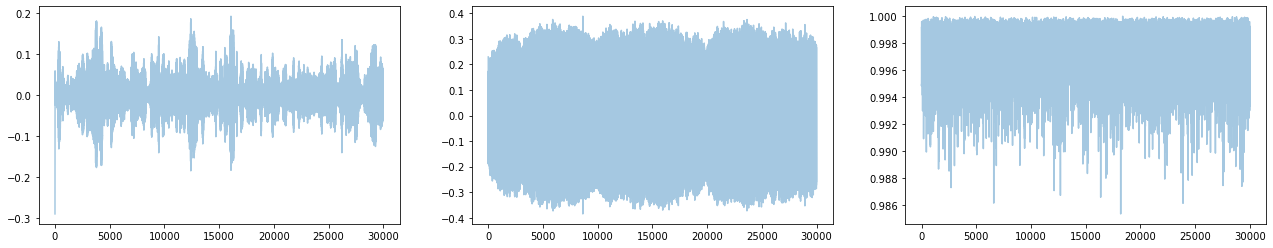

In [78]:
fig, ax = plt.subplots(1, 3, figsize=(22, 4))

theta.eps.plot(ax=ax[0], alpha=0.4)
theta.dtau.plot(ax=ax[1], alpha=0.4)
theta.ps.plot(ax=ax[2], alpha=0.4)

<AxesSubplot:>

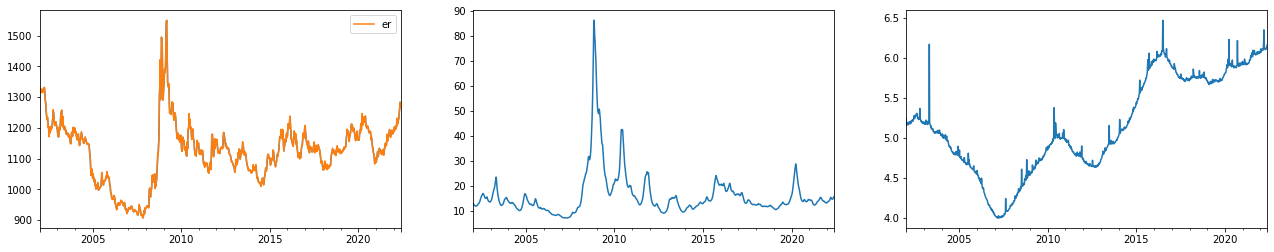

In [86]:
fig, ax = plt.subplots(1, 3, figsize=(22, 4))

tau_draws.loc[5000:, :].mean(axis=0).loc['2002':].plot(ax=ax[0])
data.loc['2002':].plot(ax=ax[0])
sigma_dtau_draws.loc[5000:, :].mean(axis=0).loc['2002':].plot(ax=ax[1])
sigma_total_eps_draws.loc[5000:, :].mean(axis=0).loc['2002':].plot(ax=ax[2])

<AxesSubplot:>

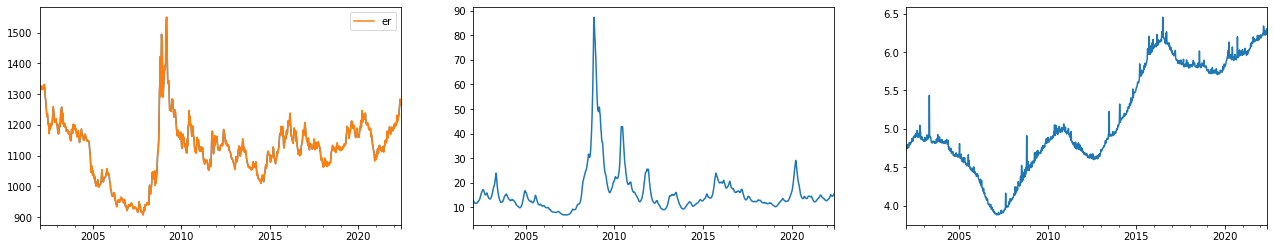

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(22, 4))

tau_draws.iloc[sel_draws, :].mean(axis=0).loc['2002':].plot(ax=ax[0])
data.loc['2002':].plot(ax=ax[0])
sigma_dtau_draws.iloc[sel_draws, :].mean(axis=0).loc['2002':].plot(ax=ax[1])
sigma_total_eps_draws.iloc[sel_draws, :].mean(axis=0).loc['2002':].plot(ax=ax[2])

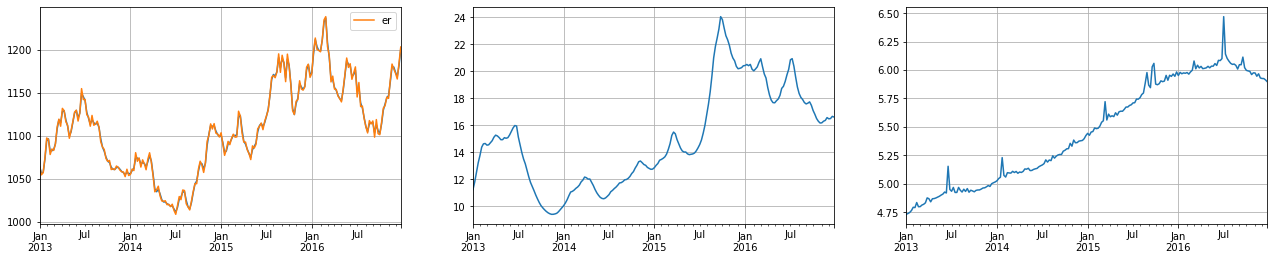

In [75]:
fig, ax = plt.subplots(1, 3, figsize=(22, 4))

tau_draws.loc[5000:, :].mean(axis=0).loc['2013':'2016'].plot(ax=ax[0])
data.loc['2013':'2016'].plot(ax=ax[0])
sigma_dtau_draws.loc[5000:, :].mean(axis=0).loc['2013':'2016'].plot(ax=ax[1])
sigma_total_eps_draws.loc[5000:, :].mean(axis=0).loc['2013':'2016'].plot(ax=ax[2])
for a in ax:
    a.grid()

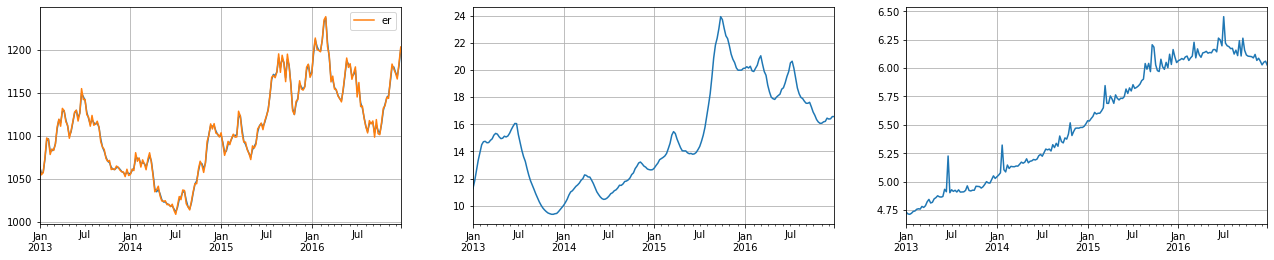

In [93]:
fig, ax = plt.subplots(1, 3, figsize=(22, 4))

tau_draws.iloc[sel_draws, :].mean(axis=0).loc['2013':'2016'].plot(ax=ax[0])
data.loc['2013':'2016'].plot(ax=ax[0])
sigma_dtau_draws.iloc[sel_draws, :].mean(axis=0).loc['2013':'2016'].plot(ax=ax[1])
sigma_total_eps_draws.iloc[sel_draws, :].mean(axis=0).loc['2013':'2016'].plot(ax=ax[2])
for a in ax:
    a.grid()

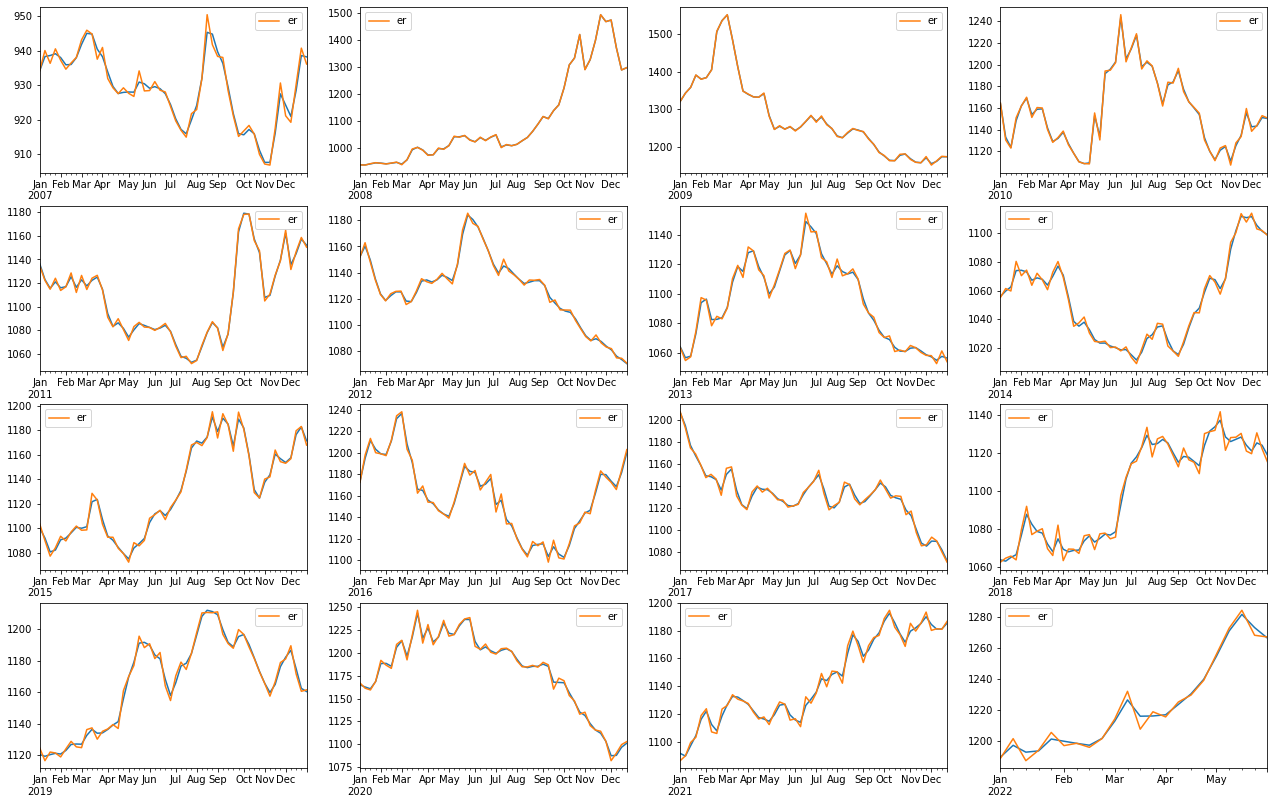

In [72]:
yrs = range(2007, 2023)

fig, ax = plt.subplots(4, 4, figsize=(22, 14))

for i, yr in enumerate(yrs):
    tau_draws.loc[5000:, :].mean(axis=0).loc[str(yr)].plot(ax=ax.ravel()[i])
    data.loc[str(yr)].plot(ax=ax.ravel()[i])

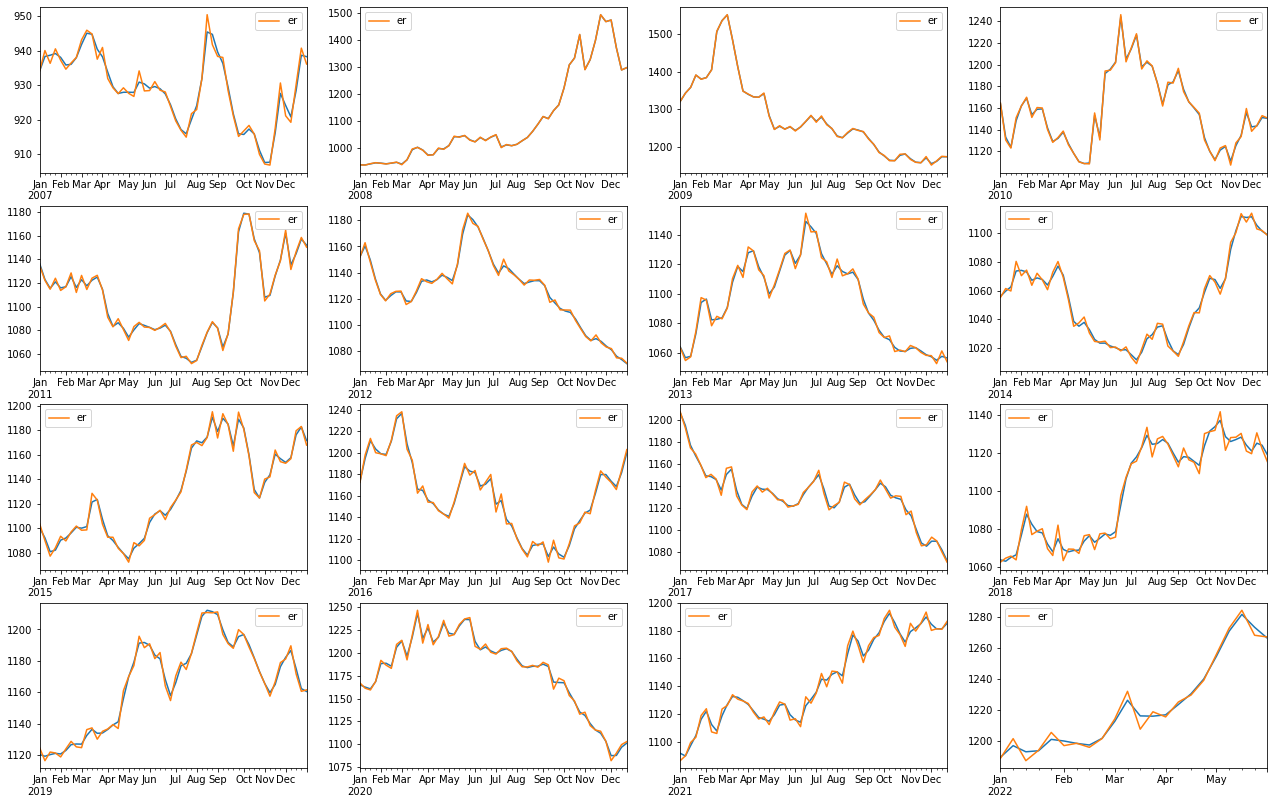

In [88]:
yrs = range(2007, 2023)

fig, ax = plt.subplots(4, 4, figsize=(22, 14))

for i, yr in enumerate(yrs):
    tau_draws.loc[sel_draws, :].mean(axis=0).loc[str(yr)].plot(ax=ax.ravel()[i])
    data.loc[str(yr)].plot(ax=ax.ravel()[i])

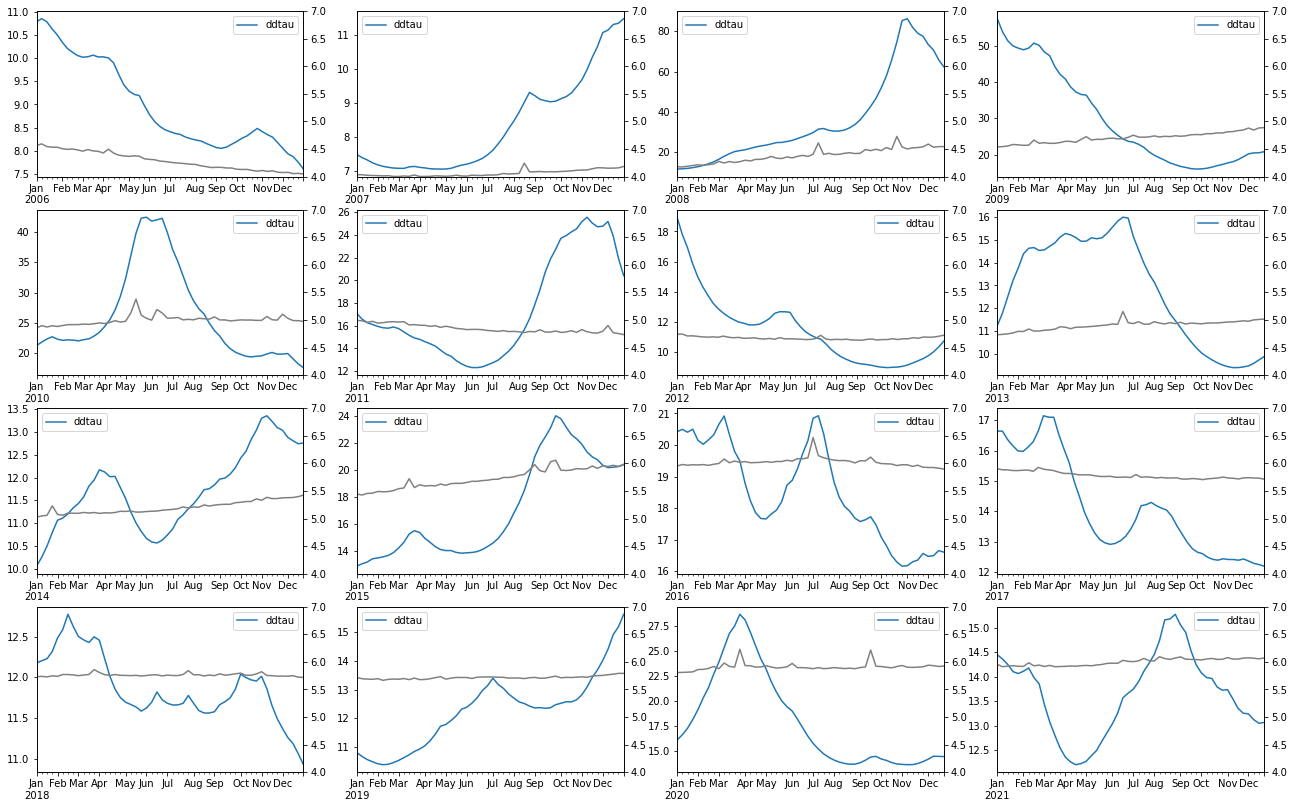

In [70]:
yrs = range(2006, 2022)
fig, ax = plt.subplots(4, 4, figsize=(22, 14))

for i, yr in enumerate(yrs):
    sigma_dtau_mean.loc[str(yr)].plot(ax=ax.ravel()[i], label='ddtau')
    ax1 = ax.ravel()[i].twinx()
    sigma_total_eps_mean.loc[str(yr)].plot(ax=ax1, color='gray', label='total_eps')
    ax1.set_ylim(4, 7)
    ax.ravel()[i].legend()

<AxesSubplot:>

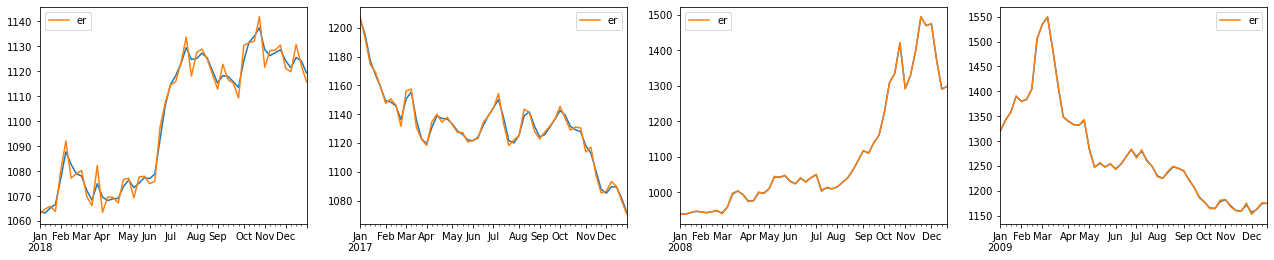

In [51]:
fig, ax = plt.subplots(1, 4, figsize=(22, 4))

tau_draws.loc[5000:, :].mean(axis=0).loc['2018'].plot(ax=ax[0])
data.loc['2018'].plot(ax=ax[0])

tau_draws.loc[5000:, :].mean(axis=0).loc['2017'].plot(ax=ax[1])
data.loc['2017'].plot(ax=ax[1])

tau_draws.loc[5000:, :].mean(axis=0).loc['2008'].plot(ax=ax[2])
data.loc['2008'].plot(ax=ax[2])

tau_draws.loc[5000:, :].mean(axis=0).loc['2009'].plot(ax=ax[3])
data.loc['2009'].plot(ax=ax[3])

In [106]:
"""nper = 250, 
h0 = log(stat.variance(y))/1
g0 = log(stat.variance(y[1:] - y[:-1]))/1
tau0 = mean(y)
dtau0 = mean(y[1:] - y[:-1])
omegah = sqrt(.2)/1
omegag = sqrt(.2)/1"""

'nper = 250, \nh0 = log(stat.variance(y))/1\ng0 = log(stat.variance(y[1:] - y[:-1]))/1\ntau0 = mean(y)\ndtau0 = mean(y[1:] - y[:-1])\nomegah = sqrt(.2)/1\nomegag = sqrt(.2)/1'

<AxesSubplot:>

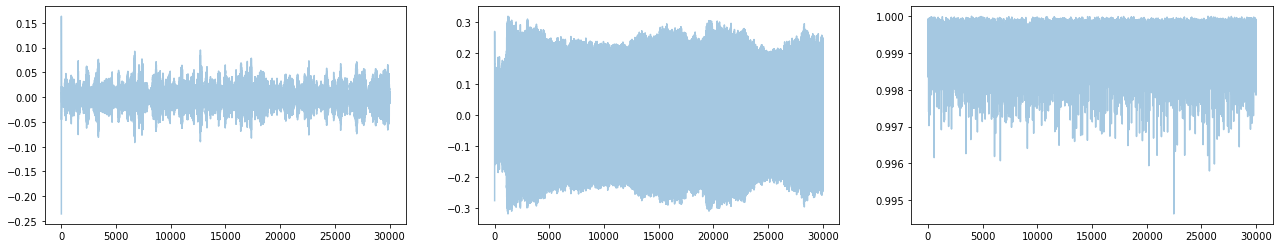

In [112]:
fig, ax = plt.subplots(1, 3, figsize=(22, 4))

theta.eps.plot(ax=ax[0], alpha=0.4)
theta.dtau.plot(ax=ax[1], alpha=0.4)
theta.ps.plot(ax=ax[2], alpha=0.4)

<AxesSubplot:>

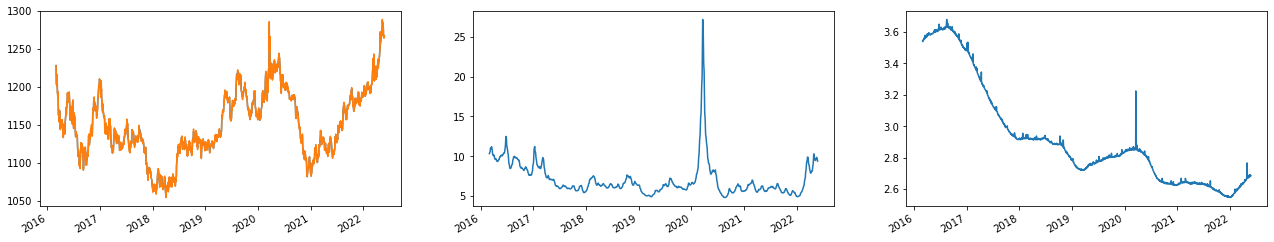

In [108]:
fig, ax = plt.subplots(1, 3, figsize=(22, 4))

tau_draws.loc[10000:, :].mean(axis=0).loc['2016-03':].plot(ax=ax[0])
data.loc['2016-03':].plot(ax=ax[0])
sigma_dtau_draws.loc[10000:, :].mean(axis=0).loc['2016-03':].plot(ax=ax[1])
sigma_total_eps_draws.loc[10000:, :].mean(axis=0).loc['2016-03':].plot(ax=ax[2])

<AxesSubplot:>

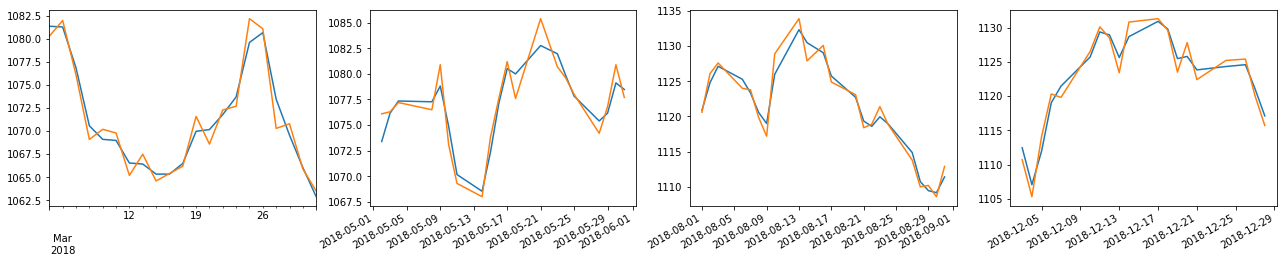

In [109]:
fig, ax = plt.subplots(1, 4, figsize=(22, 4))

tau_draws.loc[10000:, :].mean(axis=0).loc['2018-03'].plot(ax=ax[0])
data.loc['2018-03'].plot(ax=ax[0])

tau_draws.loc[10000:, :].mean(axis=0).loc['2018-05'].plot(ax=ax[1])
data.loc['2018-05'].plot(ax=ax[1])

tau_draws.loc[10000:, :].mean(axis=0).loc['2018-08'].plot(ax=ax[2])
data.loc['2018-08'].plot(ax=ax[2])

tau_draws.loc[10000:, :].mean(axis=0).loc['2018-12'].plot(ax=ax[3])
data.loc['2018-12'].plot(ax=ax[3])

In [98]:
"""nper = 250, 
h0 = log(stat.variance(y))/5
g0 = log(stat.variance(y[1:] - y[:-1]))/50
tau0 = mean(y)
dtau0 = mean(y[1:] - y[:-1])
omegah = sqrt(.2)
omegag = sqrt(.2)/20"""

'nper = 250, \nh0 = log(stat.variance(y))/5\ng0 = log(stat.variance(y[1:] - y[:-1]))/50\ntau0 = mean(y)\ndtau0 = mean(y[1:] - y[:-1])\nomegah = sqrt(.2)\nomegag = sqrt(.2)/20'

<AxesSubplot:>

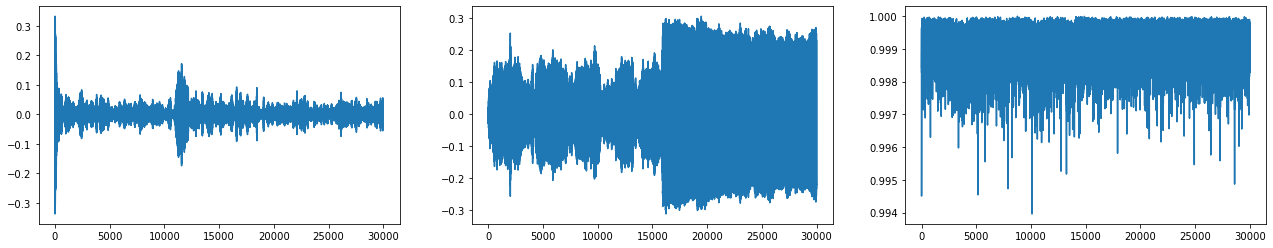

In [99]:
fig, ax = plt.subplots(1, 3, figsize=(22, 4))

theta.eps.plot(ax=ax[0])
theta.dtau.plot(ax=ax[1])
theta.ps.plot(ax=ax[2])

<AxesSubplot:>

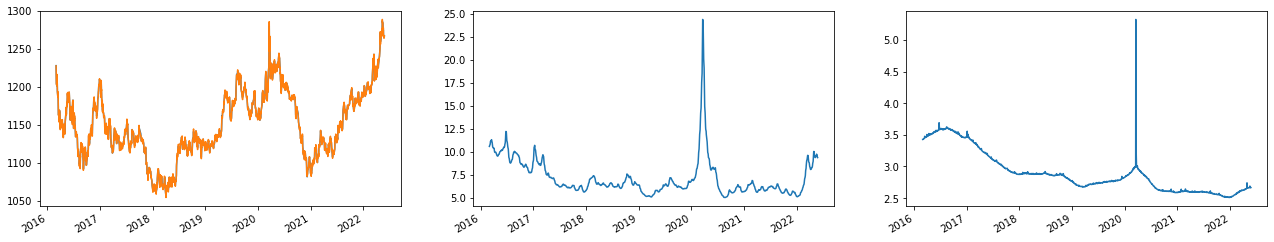

In [100]:
fig, ax = plt.subplots(1, 3, figsize=(22, 4))

tau_draws.loc[10000:, :].mean(axis=0).loc['2016-03':].plot(ax=ax[0])
data.loc['2016-03':].plot(ax=ax[0])
sigma_dtau_draws.loc[10000:, :].mean(axis=0).loc['2016-03':].plot(ax=ax[1])
sigma_total_eps_draws.loc[10000:, :].mean(axis=0).loc['2016-03':].plot(ax=ax[2])

<AxesSubplot:>

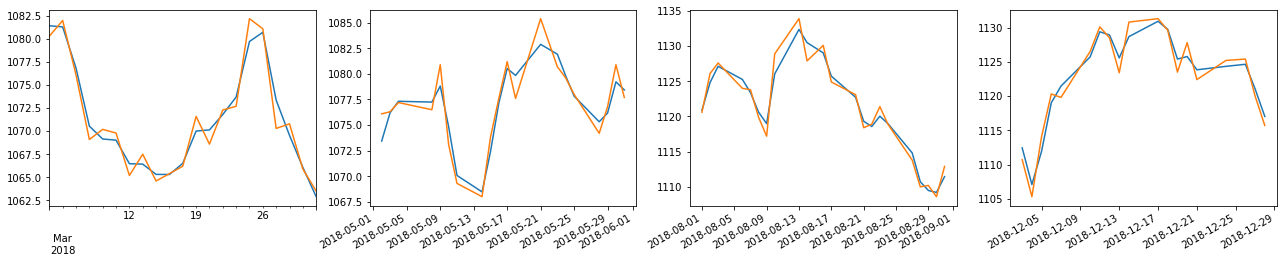

In [101]:
fig, ax = plt.subplots(1, 4, figsize=(22, 4))

tau_draws.loc[10000:, :].mean(axis=0).loc['2018-03'].plot(ax=ax[0])
data.loc['2018-03'].plot(ax=ax[0])

tau_draws.loc[10000:, :].mean(axis=0).loc['2018-05'].plot(ax=ax[1])
data.loc['2018-05'].plot(ax=ax[1])

tau_draws.loc[10000:, :].mean(axis=0).loc['2018-08'].plot(ax=ax[2])
data.loc['2018-08'].plot(ax=ax[2])

tau_draws.loc[10000:, :].mean(axis=0).loc['2018-12'].plot(ax=ax[3])
data.loc['2018-12'].plot(ax=ax[3])

In [73]:
"""nper = 50, 
h0 = log(stat.variance(y))/5
g0 = log(stat.variance(y[1:] - y[:-1]))/20
tau0 = mean(y)
dtau0 = mean(y[1:] - y[:-1])
omegah = sqrt(.2)
omegag = sqrt(.2)/10"""

'nper = 50, \nh0 = log(stat.variance(y))/5\ng0 = log(stat.variance(y[1:] - y[:-1]))/20\ntau0 = mean(y)\ndtau0 = mean(y[1:] - y[:-1])\nomegah = sqrt(.2)\nomegag = sqrt(.2)/10'

<AxesSubplot:>

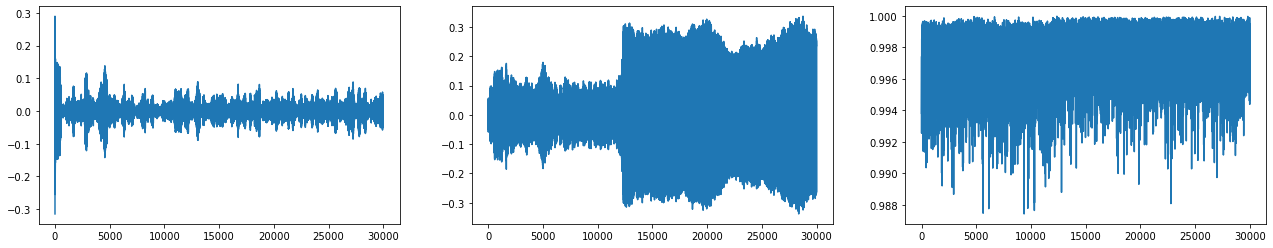

In [74]:
fig, ax = plt.subplots(1, 3, figsize=(22, 4))

theta.eps.plot(ax=ax[0])
theta.dtau.plot(ax=ax[1])
theta.ps.plot(ax=ax[2])

<AxesSubplot:>

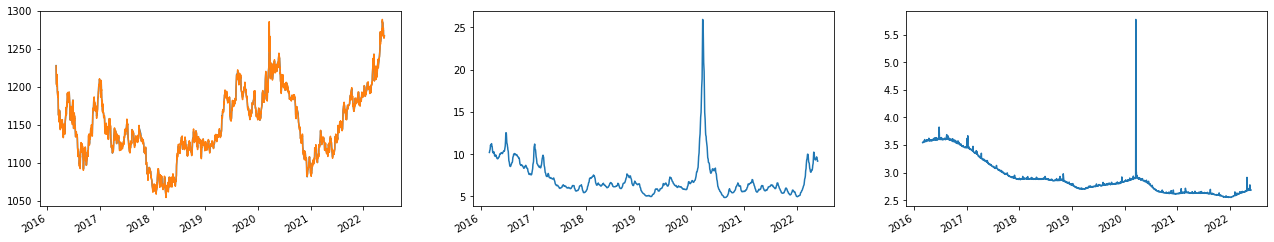

In [75]:
fig, ax = plt.subplots(1, 3, figsize=(22, 4))

tau_draws.loc[10000:, :].mean(axis=0).loc['2016-03':].plot(ax=ax[0])
data.loc['2016-03':].plot(ax=ax[0])
sigma_dtau_draws.loc[10000:, :].mean(axis=0).loc['2016-03':].plot(ax=ax[1])
sigma_total_eps_draws.loc[10000:, :].mean(axis=0).loc['2016-03':].plot(ax=ax[2])

<AxesSubplot:>

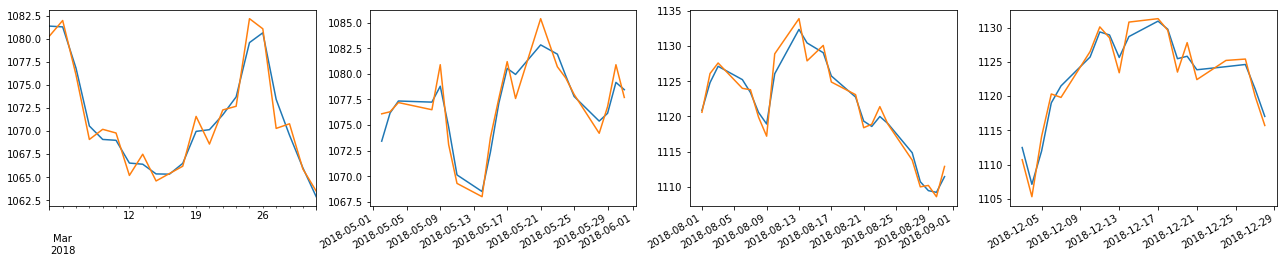

In [76]:
fig, ax = plt.subplots(1, 4, figsize=(22, 4))

tau_draws.loc[10000:, :].mean(axis=0).loc['2018-03'].plot(ax=ax[0])
data.loc['2018-03'].plot(ax=ax[0])

tau_draws.loc[10000:, :].mean(axis=0).loc['2018-05'].plot(ax=ax[1])
data.loc['2018-05'].plot(ax=ax[1])

tau_draws.loc[10000:, :].mean(axis=0).loc['2018-08'].plot(ax=ax[2])
data.loc['2018-08'].plot(ax=ax[2])

tau_draws.loc[10000:, :].mean(axis=0).loc['2018-12'].plot(ax=ax[3])
data.loc['2018-12'].plot(ax=ax[3])

In [ ]:
"""nper = 252, 
h0 = log(stat.variance(y))/5
g0 = log(stat.variance(y[1:] - y[:-1]))/20
tau0 = mean(y)
dtau0 = mean(y[1:] - y[:-1])
omegah = sqrt(.2)
omegag = sqrt(.2)/10"""

<AxesSubplot:>

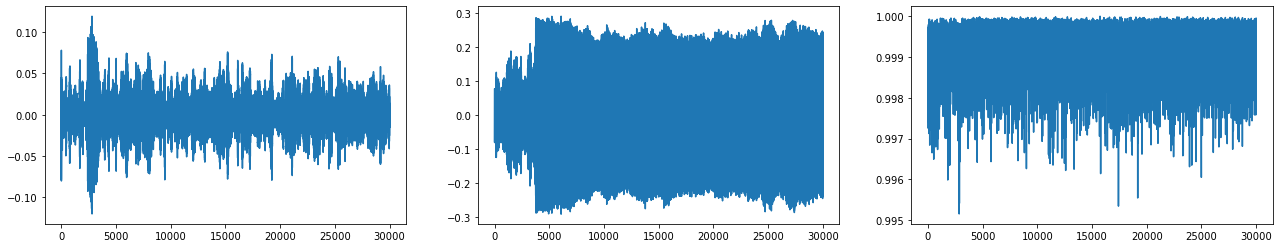

In [62]:
fig, ax = plt.subplots(1, 3, figsize=(22, 4))

theta.eps.plot(ax=ax[0])
theta.dtau.plot(ax=ax[1])
theta.ps.plot(ax=ax[2])

<AxesSubplot:>

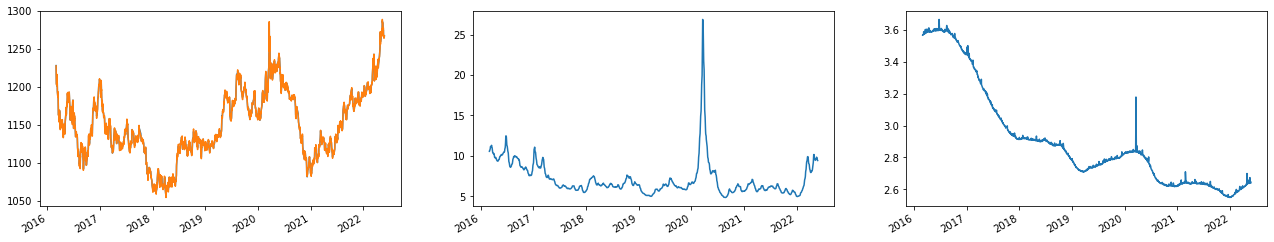

In [68]:
fig, ax = plt.subplots(1, 3, figsize=(22, 4))

tau_draws.loc[10000:, :].mean(axis=0).loc['2016-03':].plot(ax=ax[0])
data.loc['2016-03':].plot(ax=ax[0])
sigma_dtau_draws.loc[10000:, :].mean(axis=0).loc['2016-03':].plot(ax=ax[1])
sigma_total_eps_draws.loc[10000:, :].mean(axis=0).loc['2016-03':].plot(ax=ax[2])

<AxesSubplot:>

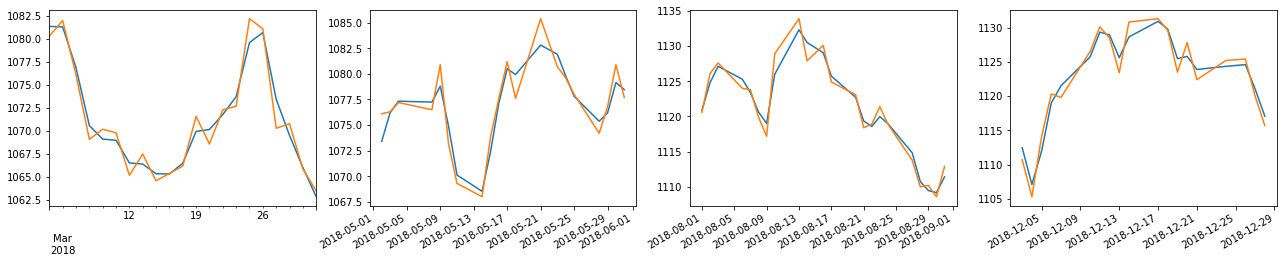

In [66]:
fig, ax = plt.subplots(1, 4, figsize=(22, 4))

tau_draws.loc[10000:, :].mean(axis=0).loc['2018-03'].plot(ax=ax[0])
data.loc['2018-03'].plot(ax=ax[0])

tau_draws.loc[10000:, :].mean(axis=0).loc['2018-05'].plot(ax=ax[1])
data.loc['2018-05'].plot(ax=ax[1])

tau_draws.loc[10000:, :].mean(axis=0).loc['2018-08'].plot(ax=ax[2])
data.loc['2018-08'].plot(ax=ax[2])

tau_draws.loc[10000:, :].mean(axis=0).loc['2018-12'].plot(ax=ax[3])
data.loc['2018-12'].plot(ax=ax[3])

In [54]:
trend = tau_draws.mean(axis=0)
ntrend = ((trend - trend.mean())/trend.std())
ndata = ((data - data.mean())/data.std())

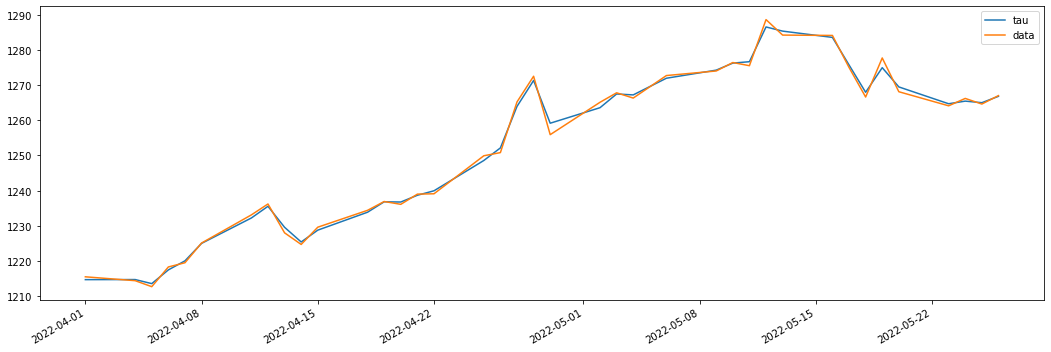

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))

tau_draws.loc[20000:, :].mean(axis=0).loc['2022-04':].plot(ax=ax, label='tau')
data.loc['2022-04':].plot(ax=ax, label='data')
ax.legend()

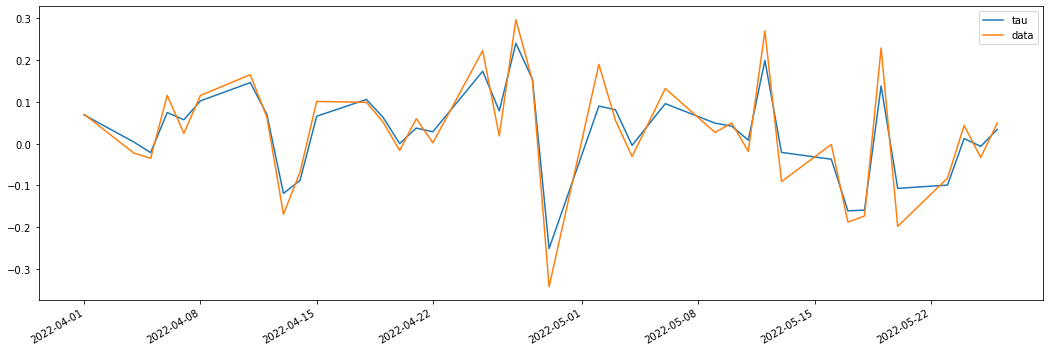

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))

ntrend.diff().loc['2022-04':].plot(ax=ax, label='tau')
ndata.diff().loc['2022-04':].plot(ax=ax, label='data')
ax.legend()

<AxesSubplot:>

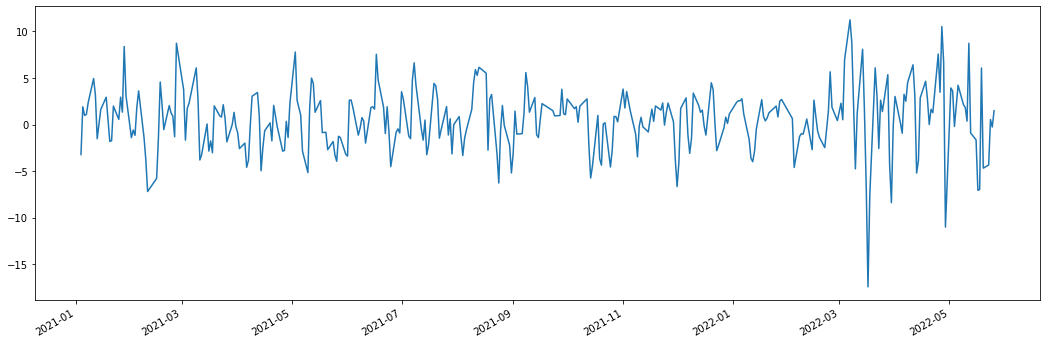

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))

dtau_draws.loc[10000:, :].mean(axis=0).loc['2021':].plot(ax=ax)

In [83]:
np.savez('cpi_1966.npz', tau_draws=tau_draws, sigma_dtau_draws=sigma_dtau_draws, sigma_eps_draws=sigma_eps_draws, 
         g_eps_draws=g_eps_draws, g_dtau_draws=g_dtau_draws, scl_eps_draws=scl_eps_draws, sigma_total_eps_draws=sigma_total_eps_draws,
         ps_draws=ps_draws)
# npzfile = np.load('chan2018.npz')

In [84]:
np.savez('cpi_1985.npz', tau_draws=tau_draws, sigma_dtau_draws=sigma_dtau_draws, sigma_eps_draws=sigma_eps_draws, 
         g_eps_draws=g_eps_draws, g_dtau_draws=g_dtau_draws, scl_eps_draws=scl_eps_draws, sigma_total_eps_draws=sigma_total_eps_draws,
         ps_draws=ps_draws)
# npzfile = np.load('chan2018.npz')

In [85]:
np.savez('d1lP_q.npz', tau_draws=tau_draws, sigma_dtau_draws=sigma_dtau_draws, sigma_eps_draws=sigma_eps_draws, 
         g_eps_draws=g_eps_draws, g_dtau_draws=g_dtau_draws, scl_eps_draws=scl_eps_draws, sigma_total_eps_draws=sigma_total_eps_draws,
         ps_draws=ps_draws)
# npzfile = np.load('chan2018.npz')

# Result

# 1966년 이후

In [86]:
# load npz file
npzfile = np.load('cpi_1985.npz')

tau_draws = npzfile['tau_draws']
sigma_dtau_draws = npzfile['sigma_dtau_draws']
sigma_eps_draws = npzfile['sigma_eps_draws']
g_eps_draws = npzfile['g_eps_draws']
g_dtau_draws = npzfile['g_dtau_draws']
scl_eps_draws = npzfile['scl_eps_draws']
sigma_total_eps_draws = npzfile['sigma_total_eps_draws']
ps_draws = npzfile['ps_draws']

# Rescale so that things are in units of y
scaled_draws = [tau_draws, sigma_dtau_draws, sigma_eps_draws, sigma_total_eps_draws]
for draws in scaled_draws:
    draws = draws*scale_y

tau_draws = pd.DataFrame(tau_draws, columns=data.index)
sigma_dtau_draws = pd.DataFrame(sigma_dtau_draws, columns=data.index)
sigma_eps_draws = pd.DataFrame(sigma_eps_draws, columns=data.index)
sigma_total_eps_draws = pd.DataFrame(sigma_total_eps_draws, columns=data.index)
scl_eps_draws = pd.DataFrame(scl_eps_draws, columns=data.index)
theta = pd.DataFrame({'eps':g_eps_draws, 'dtau':g_dtau_draws, 'ps':ps_draws})
ps_draws = pd.Series(ps_draws)

<AxesSubplot:>

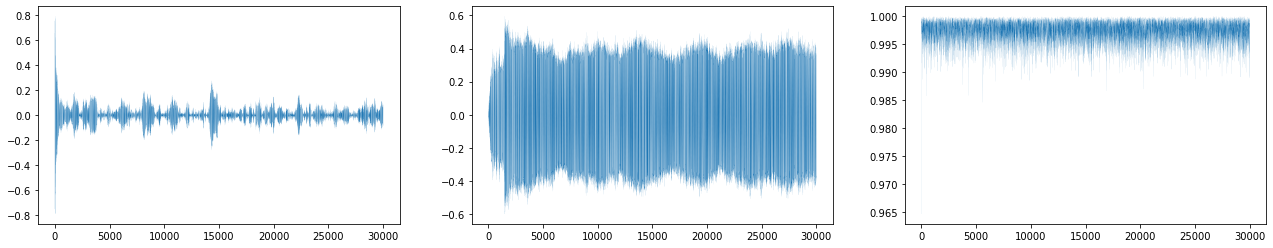

In [87]:
fig, ax = plt.subplots(1, 3, figsize=(22, 4))

theta['eps'].plot(ax=ax[0], lw=0.05)
theta['dtau'].plot(ax=ax[1], lw=0.05)
theta['ps'].plot(ax=ax[2], lw=0.05)

<AxesSubplot:xlabel='Date'>

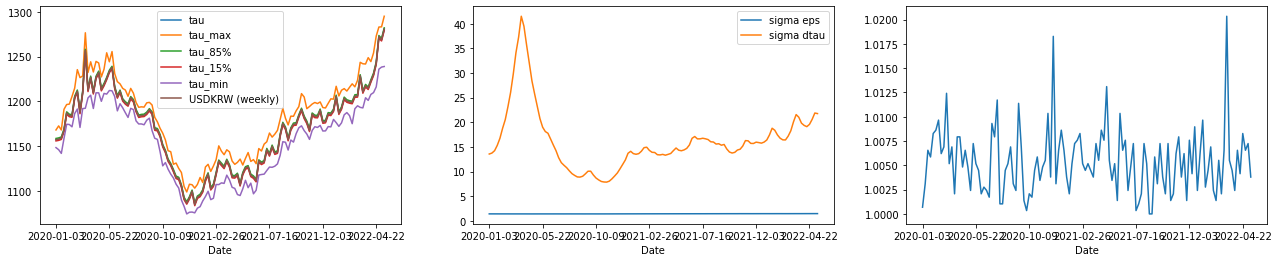

In [88]:
start_year = '2020'

# plot 1
fig, ax = plt.subplots(1, 3, figsize=(22, 4))

tau_mean = tau_draws.loc[used_draws].mean(axis=0)
tau_mean *= scale_y
tau_mean.loc[start_year:].plot(ax=ax[0], label='tau')

dtau_draws_ = pd.DataFrame(data=dtau_draws, 
                           index=tau_draws.index, columns=tau_draws.columns)
dtau_mean = dtau_draws_.loc[used_draws].mean(axis=0)
#dtau_mean *= scale_y
#dtau_mean.loc[start_year:].plot(ax=ax[0], label='tau')

np.max(tau_draws, axis=0).loc[start_year:].plot(ax=ax[0], label='tau_max')

perc_85 = np.percentile(tau_draws, 85, axis=0)
ser_85pct = pd.Series(data=perc_85, index=tau_draws.columns)
ser_85pct.loc[start_year:].plot(ax=ax[0], label='tau_85%')  # higher value than 15pct

perc_15 = np.percentile(tau_draws, 15, axis=0)  # top 15%
ser_15pct = pd.Series(data=perc_15, index=tau_draws.columns)
ser_15pct.loc[start_year:].plot(ax=ax[0], label='tau_15%')

np.min(tau_draws, axis=0).loc[start_year:].plot(ax=ax[0], label='tau_min')

usdkrw = data['weekly']
usdkrw.loc[start_year:].plot(ax=ax[0], label='USDKRW (weekly)')

# plot 2
ax[0].legend()
eps_mean = sigma_eps_draws.loc[used_draws].mean(axis=0)
eps_mean.loc[start_year:].plot(ax=ax[1], label='sigma eps')      # = exp(.5 * (h0 + omega_h*htilda))
dtau_mean = sigma_dtau_draws.loc[used_draws].mean(axis=0)
dtau_mean.loc[start_year:].plot(ax=ax[1], label='sigma dtau')    # = exp(.5 * (g0 + omega_g*gtilda))

# plot 3
ax[1].legend()
scl_eps_mean = scl_eps_draws.loc[used_draws].mean(axis=0)
scl_eps_mean.loc[start_year:].plot(ax=ax[2])

In [89]:
tau_draws.iloc[:,0]

0        1183.033377
1        1188.672000
2        1184.708748
3        1184.064907
4        1185.503524
            ...     
29995    1184.542112
29996    1182.522938
29997    1187.097283
29998    1182.319631
29999    1183.628565
Name: 2003-12-05, Length: 30000, dtype: float64

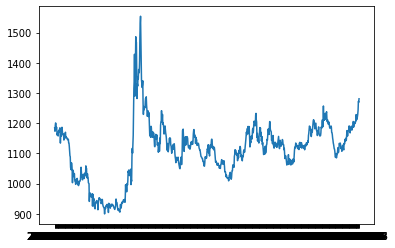

In [90]:
plt.plot(tau_mean)

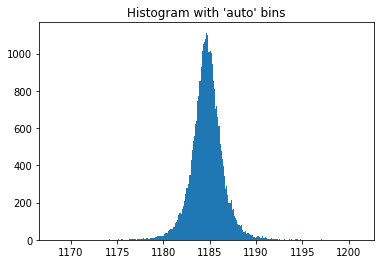

In [91]:
import matplotlib.pyplot as plt
_ = plt.hist(tau_draws.iloc[:,0], bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

### Projection (1 months)

- Here, I add a projection using the variables obtained recently

In [92]:
def error_measures(arr, type=0):
    '''
    Input error array, this will return average measure according to type
    0: RMSE
    1: MSE
    2: MAE
    3: True pct
    '''
    if type == 0:
        avg = (sum(n ** 2 for n in arr) / len(arr)) ** .5
        #print(f'RMSE: {round(avg)}')
        return avg
    elif type == 1:
        avg = sum(n ** 2 for n in arr) / len(arr)
        #print(f'MSE: {round(avg)}')
        return avg
    elif type == 2:
        avg = sum(abs(n) for n in arr) / len(arr)
        #print(f'MAE: {round(avg)}')
        return avg
    elif type == 3:
        avg = sum(arr) / len(arr)
        #print(f'True pct: {round(avg)}')
        return avg
    else:
        raise(KeyError, "Error")

In [93]:
# Point est. error measure

forecast = {}
error = {}

'''
idx   0 i
X     ....................
y     ....................
yhat    ....................  <- WEEK=1 ahead 'forecast'

error   ..................   -> avg (y-yhat)**2 -> RMSE
idx     0
'''

for WEEK in range(1,5):
    forecast[WEEK] = [tau_mean.iloc[i] + WEEK * dtau_mean.iloc[i] for i in range(len(dtau_mean))]
    error[WEEK] = [y[i+WEEK] - forecast[WEEK][i] for i in range(len(forecast[WEEK])-WEEK)]
    print(f"Week {WEEK} RMSE: {round(error_measures(error[WEEK]),1)}")

Week 1 RMSE: 37.1
Week 2 RMSE: 70.0
Week 3 RMSE: 103.3
Week 4 RMSE: 136.8


<ipython-input-92-8c1ab754b394>:10: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  avg = (sum(n ** 2 for n in arr) / len(arr)) ** .5


In [94]:
# Range forecast 70% coverage ratio
forecast = {}   # duplicate
within_boundary = {}

for WEEK in range(1,5):
    forecast[WEEK] = [tau_mean.iloc[i] + WEEK * dtau_mean.iloc[i] for i in range(len(dtau_mean))]
    within_boundary[WEEK] = [True if ser_15pct[i+WEEK] <= forecast[WEEK][i] <= ser_85pct[i+WEEK] else False
                   for i in range(len(forecast[WEEK])-WEEK)]
    print(f"Week {WEEK} PERC: {round(error_measures(within_boundary[WEEK], 3), 1)}")

Week 1 PERC: 0.0
Week 2 PERC: 0.0
Week 3 PERC: 0.0
Week 4 PERC: 0.0


In [95]:
ser_15pct

Date
2003-12-05    1183.184833
2003-12-12    1171.695120
2003-12-19    1191.248237
2003-12-26    1199.175202
2004-01-02    1194.234665
                 ...     
2022-04-15    1228.692648
2022-04-22    1241.157758
2022-04-29    1270.588457
2022-05-06    1267.375636
2022-05-13    1279.148188
Length: 958, dtype: float64

Non-random

In [138]:
# evaluate random forest ensemble for regression
from numpy import mean
from numpy import std
#from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
# define dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# define the model
model = RandomForestRegressor(n_estimators=300, max_depth=120, random_state=0, 
                              bootstrap=True, oob_score=True,
                              n_jobs=-1)
# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error',
                           cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# OOS test
# fit the model on the train dataset
model.fit(X_train, y_train)
# make a single prediction for new data
y_hat = model.predict(X_test)
# perf
print('RMSE: ', (sum((y_test - y_hat)**2) / len(y_test)) ** .5)
#perc = sum([1 if y_test.tolist()[i] * y_hat.tolist()[i] > 0 else 0 for i in range(len(y_test))]) / len(y_test)
#print('PERC: ', perc)

MAE: -669.704 (195.494)
RMSE:  26.1306686951004


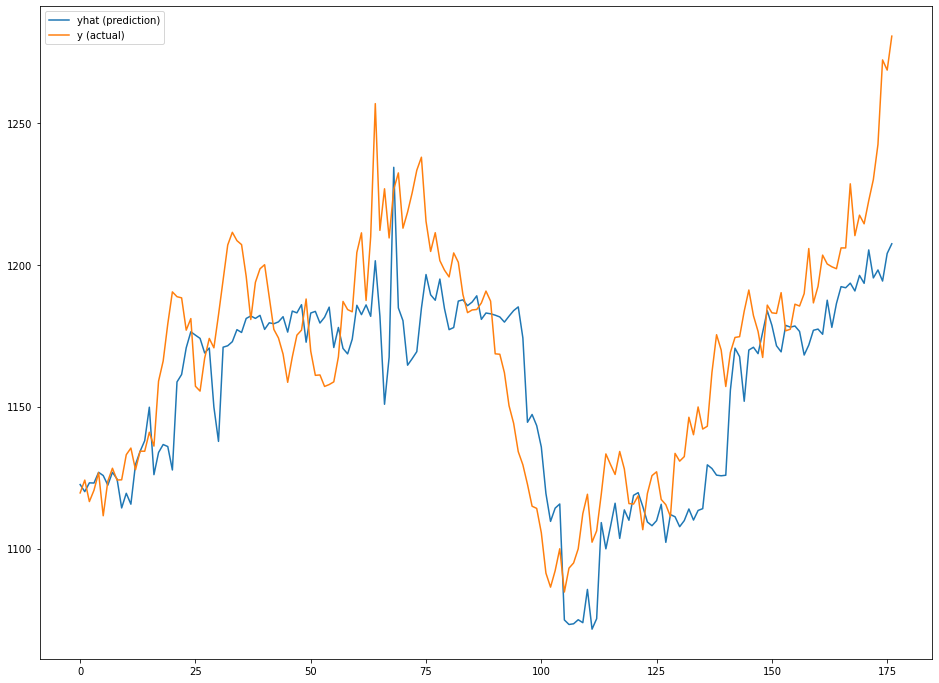

In [139]:
plt.figure(figsize=(16, 12))
plt.plot(y_hat, label='yhat (prediction)')
plt.plot(y_test, label='y (actual)')
plt.legend()

### Projection (2 weeks)

- Here, I add a projection using the variables obtained recently

In [134]:
X = df[['tau', 'eps', 'dtau', 'scleps']][:-time_difference].to_numpy()
X

array([[291.4995,   9.4791,   5.4362,   1.0331],
       [295.8384,   9.5031,   5.73  ,   1.0172],
       [290.8337,   9.4518,   5.9224,   1.0045],
       ...,
       [353.3061,   8.1303,   5.7814,   1.0141],
       [355.6575,   8.2607,   5.5909,   1.02  ],
       [357.8333,   8.2601,   5.4965,   1.0152]])

In [133]:
y = df['weekly'][time_difference:].to_numpy()
y

array([1001.7   ,  993.1   , 1007.6   ,  999.32  , 1007.7   , 1007.7   ,
       1008.6   , 1012.6   , 1031.    , 1054.3   , 1037.8   , 1021.3   ,
       1023.    , 1012.8   , 1012.3   , 1021.9   , 1031.1   , 1027.2   ,
       1026.1   , 1016.5   , 1032.9   , 1032.1   , 1035.7   , 1025.9   ,
       1058.7   , 1044.    , 1050.2   , 1024.4   , 1018.6   , 1032.6   ,
       1022.7   , 1020.3   , 1002.7   , 1001.3   ,  999.45  ,  940.71  ,
        969.24  ,  969.22  ,  967.21  ,  958.96  ,  961.91  ,  954.82  ,
        957.52  ,  957.28  ,  966.41  ,  925.23  ,  961.54  ,  964.09  ,
        942.28  ,  950.12  ,  935.61  ,  922.47  ,  929.56  ,  916.12  ,
        933.02  ,  938.02  ,  935.86  ,  941.21  ,  943.68  ,  943.61  ,
        936.46  ,  936.82  ,  912.9   ,  935.57  ,  939.6   ,  952.16  ,
        953.04  ,  950.06  ,  950.96  ,  947.33  ,  944.95  ,  947.34  ,
        933.34  ,  936.38  ,  937.47  ,  948.01  ,  947.28  ,  932.54  ,
        927.03  ,  923.51  ,  922.01  ,  920.04  , 

In [135]:
len(X), len(y)

(884, 884)

Non-random

In [138]:
# evaluate random forest ensemble for regression
from numpy import mean
from numpy import std
#from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
# define dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# define the model
model = RandomForestRegressor(n_estimators=300, max_depth=120, random_state=0, 
                              bootstrap=True, oob_score=True,
                              n_jobs=-1)
# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error',
                           cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# OOS test
# fit the model on the train dataset
model.fit(X_train, y_train)
# make a single prediction for new data
y_hat = model.predict(X_test)
# perf
print('RMSE: ', (sum((y_test - y_hat)**2) / len(y_test)) ** .5)
#perc = sum([1 if y_test.tolist()[i] * y_hat.tolist()[i] > 0 else 0 for i in range(len(y_test))]) / len(y_test)
#print('PERC: ', perc)

MAE: -669.704 (195.494)
RMSE:  26.1306686951004


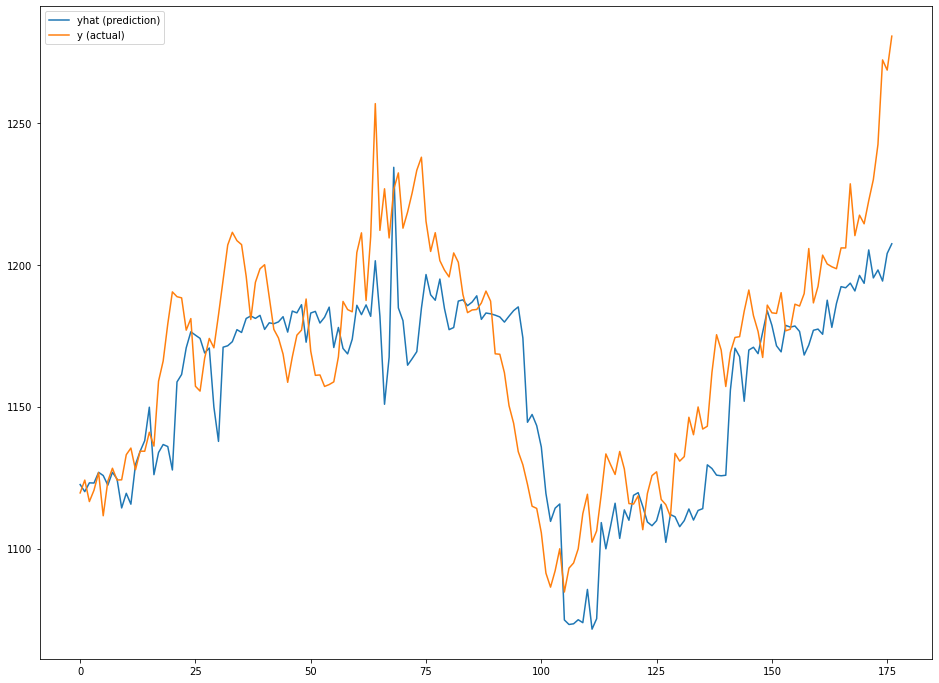

In [139]:
plt.figure(figsize=(16, 12))
plt.plot(y_hat, label='yhat (prediction)')
plt.plot(y_test, label='y (actual)')
plt.legend()

### Projection (1 months)

- Here, I add a projection using the variables obtained recently

In [134]:
X = df[['tau', 'eps', 'dtau', 'scleps']][:-time_difference].to_numpy()
X

array([[291.4995,   9.4791,   5.4362,   1.0331],
       [295.8384,   9.5031,   5.73  ,   1.0172],
       [290.8337,   9.4518,   5.9224,   1.0045],
       ...,
       [353.3061,   8.1303,   5.7814,   1.0141],
       [355.6575,   8.2607,   5.5909,   1.02  ],
       [357.8333,   8.2601,   5.4965,   1.0152]])

In [133]:
y = df['weekly'][time_difference:].to_numpy()
y

array([1001.7   ,  993.1   , 1007.6   ,  999.32  , 1007.7   , 1007.7   ,
       1008.6   , 1012.6   , 1031.    , 1054.3   , 1037.8   , 1021.3   ,
       1023.    , 1012.8   , 1012.3   , 1021.9   , 1031.1   , 1027.2   ,
       1026.1   , 1016.5   , 1032.9   , 1032.1   , 1035.7   , 1025.9   ,
       1058.7   , 1044.    , 1050.2   , 1024.4   , 1018.6   , 1032.6   ,
       1022.7   , 1020.3   , 1002.7   , 1001.3   ,  999.45  ,  940.71  ,
        969.24  ,  969.22  ,  967.21  ,  958.96  ,  961.91  ,  954.82  ,
        957.52  ,  957.28  ,  966.41  ,  925.23  ,  961.54  ,  964.09  ,
        942.28  ,  950.12  ,  935.61  ,  922.47  ,  929.56  ,  916.12  ,
        933.02  ,  938.02  ,  935.86  ,  941.21  ,  943.68  ,  943.61  ,
        936.46  ,  936.82  ,  912.9   ,  935.57  ,  939.6   ,  952.16  ,
        953.04  ,  950.06  ,  950.96  ,  947.33  ,  944.95  ,  947.34  ,
        933.34  ,  936.38  ,  937.47  ,  948.01  ,  947.28  ,  932.54  ,
        927.03  ,  923.51  ,  922.01  ,  920.04  , 

In [135]:
len(X), len(y)

(884, 884)

Non-random

In [138]:
# evaluate random forest ensemble for regression
from numpy import mean
from numpy import std
#from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
# define dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# define the model
model = RandomForestRegressor(n_estimators=300, max_depth=120, random_state=0, 
                              bootstrap=True, oob_score=True,
                              n_jobs=-1)
# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error',
                           cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# OOS test
# fit the model on the train dataset
model.fit(X_train, y_train)
# make a single prediction for new data
y_hat = model.predict(X_test)
# perf
print('RMSE: ', (sum((y_test - y_hat)**2) / len(y_test)) ** .5)
#perc = sum([1 if y_test.tolist()[i] * y_hat.tolist()[i] > 0 else 0 for i in range(len(y_test))]) / len(y_test)
#print('PERC: ', perc)

MAE: -669.704 (195.494)
RMSE:  26.1306686951004


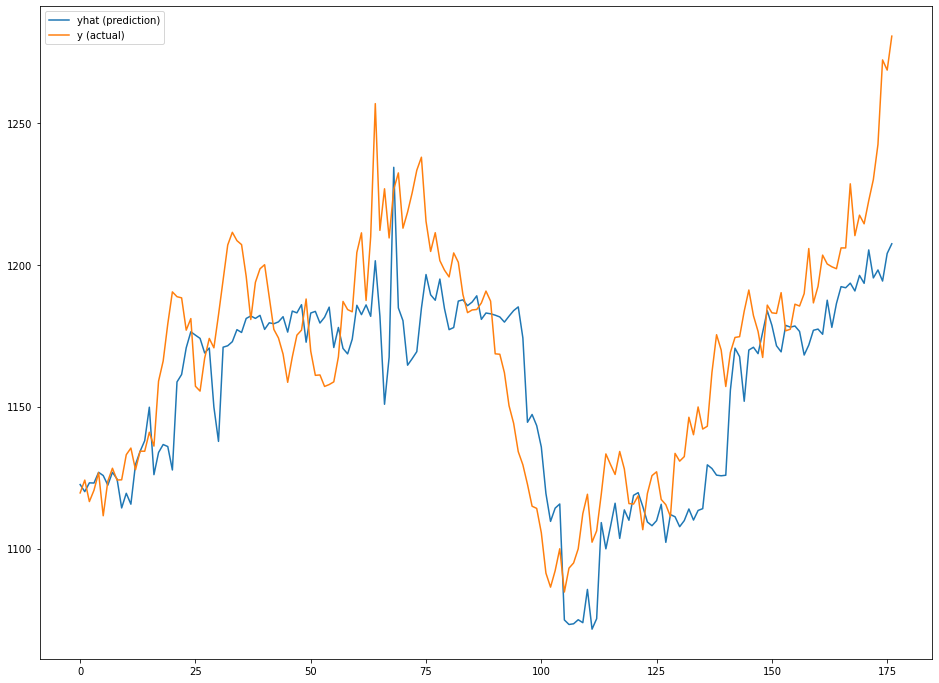

In [139]:
plt.figure(figsize=(16, 12))
plt.plot(y_hat, label='yhat (prediction)')
plt.plot(y_test, label='y (actual)')
plt.legend()

### Projection (1 months)

- Here, I add a projection using the variables obtained recently

In [ ]:
time_difference = 4

In [134]:
X = df[['tau', 'eps', 'dtau', 'scleps']][:-time_difference].to_numpy()
X

array([[291.4995,   9.4791,   5.4362,   1.0331],
       [295.8384,   9.5031,   5.73  ,   1.0172],
       [290.8337,   9.4518,   5.9224,   1.0045],
       ...,
       [353.3061,   8.1303,   5.7814,   1.0141],
       [355.6575,   8.2607,   5.5909,   1.02  ],
       [357.8333,   8.2601,   5.4965,   1.0152]])

In [133]:
y = df['weekly'][time_difference:].to_numpy()
y

array([1001.7   ,  993.1   , 1007.6   ,  999.32  , 1007.7   , 1007.7   ,
       1008.6   , 1012.6   , 1031.    , 1054.3   , 1037.8   , 1021.3   ,
       1023.    , 1012.8   , 1012.3   , 1021.9   , 1031.1   , 1027.2   ,
       1026.1   , 1016.5   , 1032.9   , 1032.1   , 1035.7   , 1025.9   ,
       1058.7   , 1044.    , 1050.2   , 1024.4   , 1018.6   , 1032.6   ,
       1022.7   , 1020.3   , 1002.7   , 1001.3   ,  999.45  ,  940.71  ,
        969.24  ,  969.22  ,  967.21  ,  958.96  ,  961.91  ,  954.82  ,
        957.52  ,  957.28  ,  966.41  ,  925.23  ,  961.54  ,  964.09  ,
        942.28  ,  950.12  ,  935.61  ,  922.47  ,  929.56  ,  916.12  ,
        933.02  ,  938.02  ,  935.86  ,  941.21  ,  943.68  ,  943.61  ,
        936.46  ,  936.82  ,  912.9   ,  935.57  ,  939.6   ,  952.16  ,
        953.04  ,  950.06  ,  950.96  ,  947.33  ,  944.95  ,  947.34  ,
        933.34  ,  936.38  ,  937.47  ,  948.01  ,  947.28  ,  932.54  ,
        927.03  ,  923.51  ,  922.01  ,  920.04  , 

In [135]:
len(X), len(y)

(884, 884)

Non-random

In [138]:
# evaluate random forest ensemble for regression
from numpy import mean
from numpy import std
#from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
# define dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# define the model
model = RandomForestRegressor(n_estimators=300, max_depth=120, random_state=0, 
                              bootstrap=True, oob_score=True,
                              n_jobs=-1)
# evaluate the model
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
n_scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error',
                           cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('MAE: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

# OOS test
# fit the model on the train dataset
model.fit(X_train, y_train)
# make a single prediction for new data
y_hat = model.predict(X_test)
# perf
print('RMSE: ', (sum((y_test - y_hat)**2) / len(y_test)) ** .5)
#perc = sum([1 if y_test.tolist()[i] * y_hat.tolist()[i] > 0 else 0 for i in range(len(y_test))]) / len(y_test)
#print('PERC: ', perc)

MAE: -669.704 (195.494)
RMSE:  26.1306686951004


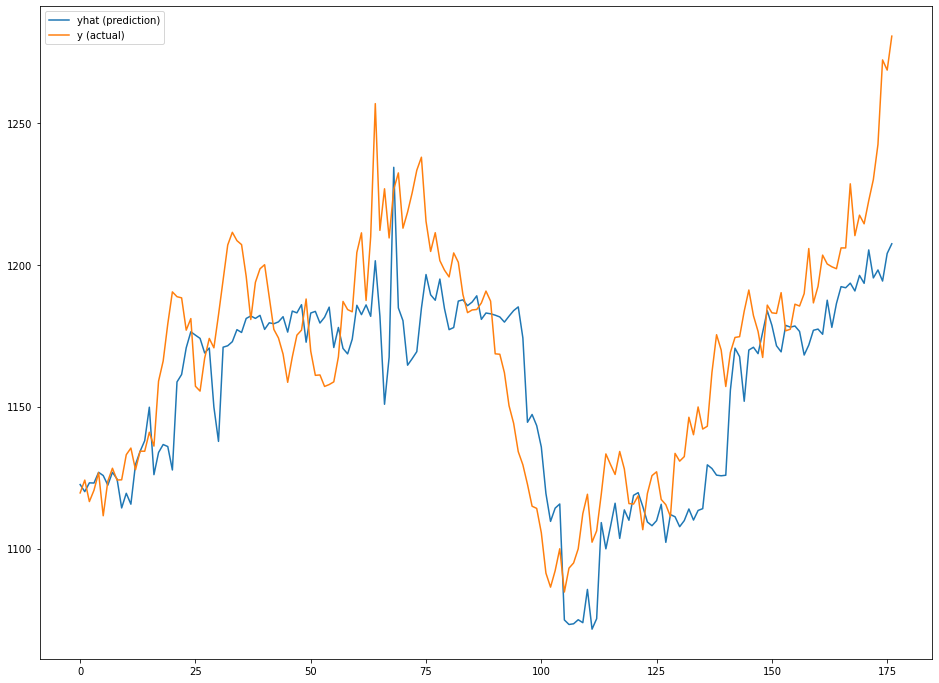

In [139]:
plt.figure(figsize=(16, 12))
plt.plot(y_hat, label='yhat (prediction)')
plt.plot(y_test, label='y (actual)')
plt.legend()